<a href="https://colab.research.google.com/github/MrNerd01/ResNet28X10-MixUpAugmentation/blob/master/RESNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cifar10 using ResNet and Data Augumentation

In [0]:
import keras
import numpy as np
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, Dense, Input, add, Activation, Flatten, AveragePooling2D
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.regularizers import l2
from keras import optimizers
from keras.models import Model

Using TensorFlow backend.


 Resnet is Implemented with **Depth** of **28** and **width** of **10** we are using **batch size** of **128** and **weight decay** of  **0.0004**

In [0]:

DEPTH              = 28
WIDE               = 10
IN_FILTERS         = 16

CLASS_NUM          = 10
IMG_ROWS, IMG_COLS = 32, 32
IMG_CHANNELS       = 3

BATCH_SIZE         = 128
EPOCHS             = 150
ITERATIONS         = 50000 // BATCH_SIZE + 1
WEIGHT_DECAY       = 0.0004
LOG_FILE_PATH      = './resnet/'

# Learning Rate

* For epochs less 50 we use learning rate of  0.1

* For epochs less 100 we use learning rate of  0.02

* For epochs less 120  we use learning rate of  0.004



In [0]:
def scheduler(epoch):
    if epoch < 50:
        return 0.1
    if epoch < 100:
        return 0.02
    if epoch < 120:
        return 0.004
    return 0.0004

#ResNet Architecture

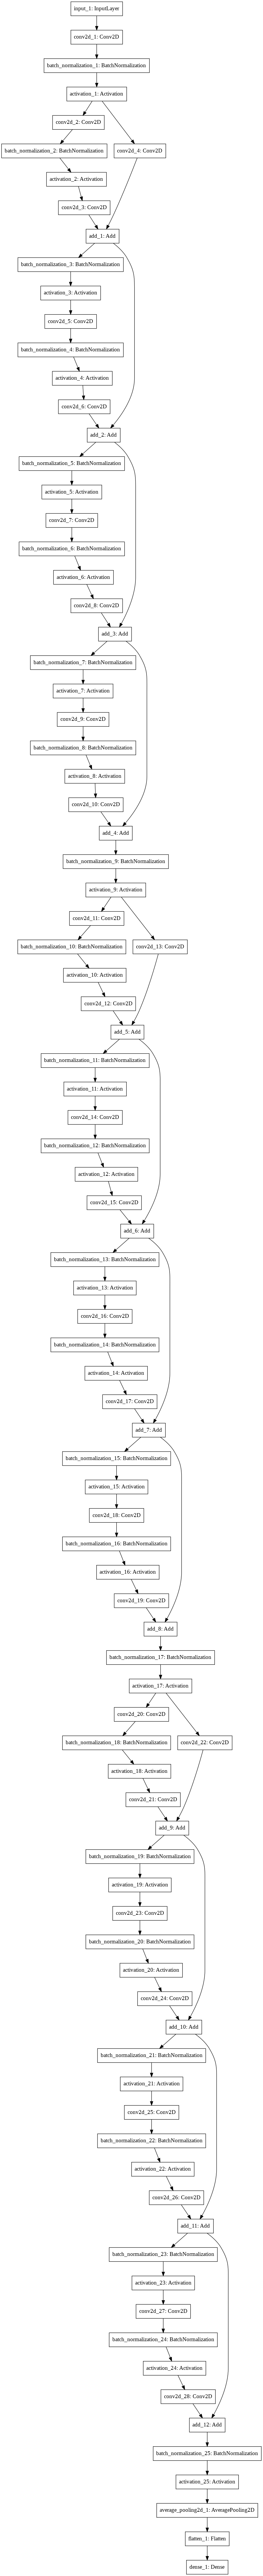

In [0]:
from IPython.display import Image
Image(filename='model.png')

**Color Preprocessing** : Advantage of preprocessing the RGB to various color spaces is that you can more readily pick what sort of features the CNN can recognize, and under what conditions those recognitions will be invariant. At the point when RGB picture is utilized as contribution to CNN, the depth of channel  is constantly equivalent to depth of picture (so if there should be an occurrence of RGB, that is 3). In this way, If 32x32x3 is the input picture, the filter must be NxNx3 (where N is height and width of channel like 3x3x3). Thus, the filter has 3 two dimensional matrices. 

In [0]:

def color_preprocessing(x_train,x_test,x_val):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_val= x_val.astype('float32')
    mean = [125.3, 123.0, 113.9]
    std  = [63.0,  62.1,  66.7]
    for i in range(3):
        x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
        x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
        x_val[:,:,:,i] = (x_val[:,:,:,i] - mean[i]) / std[i]

    return x_train, x_test, x_val

# Resnet
One of the issues ResNets illuminate is the renowned known vanishing gradient. This is on the grounds that when the network is too deep, the inclinations from where the loss function  is determined effectively shrink to zero after a few applications of the chain rule. This outcome on the weights never refreshing its values and subsequently, no learning is being performed. With ResNets, the gradients can stream directly through the skip connections in reverse from later layers to initial filters.

In [0]:
def wide_residual_network(img_input,classes_num,depth,k):
    print('Wide-Resnet %dx%d' %(depth, k))
    n_filters  = [16, 16*k, 32*k, 64*k]
    n_stack    = (depth - 4) // 6

    def conv3x3(x,filters):
        return Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1), padding='same',
        kernel_initializer='he_normal',
        kernel_regularizer=l2(WEIGHT_DECAY),
        use_bias=False)(x)

    def bn_relu(x):
        x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
        x = Activation('relu')(x)
        return x

    def residual_block(x,out_filters,increase=False):
        global IN_FILTERS
        stride = (1,1)
        if increase:
            stride = (2,2)
            
        o1 = bn_relu(x)
        
        conv_1 = Conv2D(out_filters,
            kernel_size=(3,3),strides=stride,padding='same',
            kernel_initializer='he_normal',
            kernel_regularizer=l2(WEIGHT_DECAY),
            use_bias=False)(o1)

        o2 = bn_relu(conv_1)
        
        conv_2 = Conv2D(out_filters, 
            kernel_size=(3,3), strides=(1,1), padding='same',
            kernel_initializer='he_normal',
            kernel_regularizer=l2(WEIGHT_DECAY),
            use_bias=False)(o2)
        if increase or IN_FILTERS != out_filters:
            proj = Conv2D(out_filters,
                                kernel_size=(1,1),strides=stride,padding='same',
                                kernel_initializer='he_normal',
                                kernel_regularizer=l2(WEIGHT_DECAY),
                                use_bias=False)(o1)
            block = add([conv_2, proj])
        else:
            block = add([conv_2,x])
        return block

    def wide_residual_layer(x,out_filters,increase=False):
        global IN_FILTERS
        x = residual_block(x,out_filters,increase)
        IN_FILTERS = out_filters
        for _ in range(1,int(n_stack)):
            x = residual_block(x,out_filters)
        return x


    x = conv3x3(img_input,n_filters[0])
    x = wide_residual_layer(x,n_filters[1])
    x = wide_residual_layer(x,n_filters[2],increase=True)
    x = wide_residual_layer(x,n_filters[3],increase=True)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((8,8))(x)
    x = Flatten()(x)
    x = Dense(classes_num,
        activation='softmax',
        kernel_initializer='he_normal',
        kernel_regularizer=l2(WEIGHT_DECAY),
        use_bias=False)(x)
    return x

# Download Data-sets

*we split the data-sets into training set, testing set, validation set*

* 75% of data into training set

* 8 .3 % of data into validation set

* 16.6 % of data into training set

In [0]:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, CLASS_NUM)
y_test = keras.utils.to_categorical(y_test, CLASS_NUM)

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
print((x_train.shape,y_train.shape))
print((x_test.shape,y_test.shape))

((50000, 32, 32, 3), (50000, 10))
((10000, 32, 32, 3), (10000, 10))


# Split Validation dataset from Training set 

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.1)

In [0]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))


((45000, 32, 32, 3), (45000, 10))
((5000, 32, 32, 3), (5000, 10))
((10000, 32, 32, 3), (10000, 10))


#Color Preprocessing

In [0]:
 
x_train, x_test,x_val = color_preprocessing(x_train, x_test,x_val)

# Build Network.

In [0]:
 # build network
img_input = Input(shape=(IMG_ROWS,IMG_COLS,IMG_CHANNELS))
output = wide_residual_network(img_input,CLASS_NUM,DEPTH,WIDE)
resnet = Model(img_input, output)
print(resnet.summary())

Wide-Resnet 28x10
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
___________________

# Set Optimizer

In [0]:
# set optimizer
sgd = optimizers.SGD(lr=.1, momentum=0.8, nesterov=True)
resnet.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Set Callbacks

In [0]:
change_learningrate = LearningRateScheduler(scheduler)

# Data Augumentation.
* In order to make the most of our  training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

**we use the following parameters**

*  featurewise_center: Boolean. Set input mean to 0 over the dataset, feature-wise.
 * featurewise_center=True,
* samplewise_std_normalization: Boolean. Divide each input by its std.
 * featurewise_std_normalization=True,
* rotation_range: Int. Degree range for random rotations.
 * rotation_range=90,
* width_shift_range: Float, 1-D array-like or int
 * width_shift_range=0.1,
* height_shift_range: Float, 1-D array-like or int
 * height_shift_range=0.1,
* zoom_range: Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
 * zoom_range=0.2

In [0]:
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)

datagen = ImageDataGenerator(**data_gen_args)

datagen.fit(x_train)

# Setup Checkpointer

In [0]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint('./learning.hdf5', verbose=1,save_best_only=True)

# All Callbacks

In [0]:
cbks = [change_learningrate,checkpointer]

# Train the Model

In [0]:
resnet.fit_generator(datagen.flow(x_train, y_train,batch_size=BATCH_SIZE),
                        steps_per_epoch=ITERATIONS,
                        epochs=150,
                        callbacks=cbks,
                        validation_data=(x_val, y_val))


Instructions for updating:
Use tf.cast instead.
Epoch 1/150
391/391 [==============================] - 291s 744ms/step - loss: 9.2133 - acc: 0.3511 - val_loss: 6.6360 - val_acc: 0.4404

Epoch 00001: val_loss improved from inf to 6.63604, saving model to ./learning.hdf5
Epoch 2/150
391/391 [==============================] - 280s 716ms/step - loss: 4.7610 - acc: 0.5475 - val_loss: 3.6891 - val_acc: 0.5493

Epoch 00002: val_loss improved from 6.63604 to 3.68908, saving model to ./learning.hdf5
Epoch 3/150
391/391 [==============================] - 280s 716ms/step - loss: 2.6862 - acc: 0.6593 - val_loss: 2.3998 - val_acc: 0.6336

Epoch 00003: val_loss improved from 3.68908 to 2.39982, saving model to ./learning.hdf5
Epoch 4/150
391/391 [==============================] - 280s 716ms/step - loss: 1.7406 - acc: 0.7230 - val_loss: 1.6235 - val_acc: 0.7131

Epoch 00004: val_loss improved from 2.39982 to 1.62352, saving model to ./learning.hdf5
Epoch 5/150
391/391 [==============================]

# Test Accuracy across three trails.

* Load model with weights of best accuracy.

In [0]:
resnet.load_weights('learning(5).hdf5')

# evaluate test accuracy
score = resnet.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)



Test accuracy: 95.2300%


In [0]:
# evaluate test accuracy
score = resnet.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)


Test accuracy: 95.2300%


In [0]:
# evaluate test accuracy
score = resnet.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 95.2300%


# The Resnet Produces an accuracy of 95.23% 

# ResNet with MixUp Augumentation.
* Mixup is a generic and straightforward data augmentation principle. In essence, mixup trains a neural network on convex combinations of pairs of examples and their labels. By doing so, mixup regularizes the neural network to favor simple linear behavior in-between training examples.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from random_eraser import get_random_eraser

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=get_random_eraser(v_l=0, v_h=255))

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.1)

In [0]:
from mixup_generator import MixupGenerator
generator1 = MixupGenerator(x_train, y_train, alpha=0.5,datagen=datagen)()

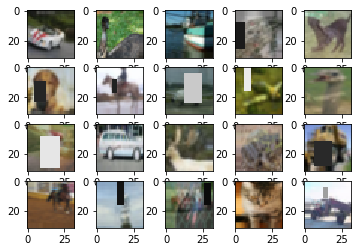

In [0]:
x, y = next(generator1)
cols, rows = 5, 4
img_num = cols * rows

for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x[i].astype(np.uint8), interpolation="nearest")
    


In [0]:
 # build network
img_input = Input(shape=(IMG_ROWS,IMG_COLS,IMG_CHANNELS))
output = wide_residual_network(img_input,CLASS_NUM,DEPTH,WIDE)
resnet = Model(img_input, output)


Wide-Resnet 28x10


In [0]:
# set optimizer
sgd = optimizers.SGD(lr=.1, momentum=0.8, nesterov=True)
resnet.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [0]:
change_learningrate = LearningRateScheduler(scheduler)

In [0]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint('./learning.hdf5', verbose=1,save_best_only=True)

In [0]:
cbks = [change_learningrate,checkpointer]

In [0]:
ITERATIONS         = 50000 // BATCH_SIZE 
print(ITERATIONS)

390


In [0]:
resnet.fit_generator(generator=generator1,
                    steps_per_epoch=ITERATIONS,
                    validation_data=(x_val,y_val),
                    epochs=200, verbose=1,
                    callbacks=cbks)

Epoch 1/200
390/390 [==============================] - 101s 259ms/step - loss: 1.9355 - acc: 0.5999 - val_loss: 1.5380 - val_acc: 0.6427

Epoch 00001: val_loss improved from 1.68274 to 1.53804, saving model to ./learning.hdf5
Epoch 2/200
390/390 [==============================] - 101s 258ms/step - loss: 1.8320 - acc: 0.6171 - val_loss: 1.4303 - val_acc: 0.6590

Epoch 00002: val_loss improved from 1.53804 to 1.43029, saving model to ./learning.hdf5
Epoch 3/200
390/390 [==============================] - 101s 258ms/step - loss: 1.7650 - acc: 0.6238 - val_loss: 2.1342 - val_acc: 0.4901

Epoch 00003: val_loss did not improve from 1.43029
Epoch 4/200
390/390 [==============================] - 101s 258ms/step - loss: 1.7227 - acc: 0.6272 - val_loss: 1.4504 - val_acc: 0.6271

Epoch 00004: val_loss did not improve from 1.43029
Epoch 5/200
390/390 [==============================] - 101s 258ms/step - loss: 1.6824 - acc: 0.6323 - val_loss: 1.5133 - val_acc: 0.5694

Epoch 00005: val_loss did not im

In [0]:
# evaluate test accuracy
resnet.load_weights('learning.hdf5')
score = resnet.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 94.7600%


In [0]:
score = resnet.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 94.7600%


In [0]:
score = resnet.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 94.7600%


# For ResNet with MixUp Augumentation we got 94.76% test accuracy 

# Observations:-
* for Resnet with Image Augumentation we get an accuracy of 95.23% of test accuracy 
* for ResNet of MIxUP Augumentation we get an accuracy of 94.76% test accuracy we would get more accuracy if the number of epocs are increased.